In [1]:
import pandas as pd
import torch
from torchvision import transforms
from PIL import Image
import os
from tqdm import tqdm
import cv2
import numpy as np
from torchvision import datasets, transforms

import torch.nn as nn
from torchvision import models
import torch.optim as optim
from torch.autograd import Variable


c:\Users\YUDE ZHOU\miniconda3\envs\pytorch8019\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
c:\Users\YUDE ZHOU\miniconda3\envs\pytorch8019\lib\site-packages\torchvision\io\image.py:13: UserWarning: Failed to load image Python extension: 
  warn(f"Failed to load image Python extension: {e}")


In [7]:

all_sample=pd.read_csv("all_sample.csv",encoding='utf-8')
all_sample['ans'] = all_sample['ans'].str.replace("wrong","not_fit")
negative_data=all_sample[all_sample["ans"]=="not_fit"]
postive_data=all_sample[all_sample["ans"]=="fit"]


#訓練2500 測試500+500
train_P=postive_data.sample(3000,random_state=178)
train_N=negative_data.sample(2985,random_state=198)
test_P=train_P.sample(500,random_state=73)
test_N=train_N.sample(485,random_state=65)

train_P=train_P.drop(test_P.index)
train_N=train_N.drop(test_N.index)

train_P=train_P.sort_values(by=["head_label","tail_label"]).reset_index(drop=True)
train_N=train_N.sort_values(by=["head_label","tail_label"]).reset_index(drop=True)
test_P=test_P.sort_values(by=["head_label","tail_label"]).reset_index(drop=True)
test_N=test_N.sort_values(by=["head_label","tail_label"]).reset_index(drop=True)

In [8]:
transform2=transforms.Compose([
    transforms.Resize([224,224]), #缩放图片，保持长宽比不变，最短边的长为224像素,
    transforms.ToTensor(), #将图片转换为Tensor,归一化至[0,1]
    transforms.Normalize(mean=[.5,.5,.5],std=[.5,.5,.5]) #标准化至[-1,1]
])

batch_size=4

train_dir = "train"           
#定義數據集
train_datasets = datasets.ImageFolder(train_dir, transform=transform2)
#加載數據集
train_dataloader = torch.utils.data.DataLoader(train_datasets, batch_size=batch_size, shuffle=True)

val_dir = "test"		
val_datasets = datasets.ImageFolder(val_dir, transform=transform2)
val_dataloader = torch.utils.data.DataLoader(val_datasets, batch_size=batch_size, shuffle=False)

In [9]:
class ResNet(nn.Module):
    def __init__(self, num_classes=2):
        super(ResNet, self).__init__()
        self.model = models.resnet18(pretrained=False)

        # 鎖定 ResNet18 預訓練模型參數
        #for param in self.model.parameters():
        #    param.requires_grad = False

        # 修改輸出層輸出數量
        self.model.fc = nn.Linear(512, 2)
    def forward(self, x):
        logits = self.model(x)
        return logits

In [10]:
model = ResNet().to("cuda")

c:\Users\YUDE ZHOU\miniconda3\envs\pytorch8019\lib\site-packages\torchvision\models\_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
c:\Users\YUDE ZHOU\miniconda3\envs\pytorch8019\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [11]:
# 損失函數
loss_func = nn.CrossEntropyLoss()

# 學習優化器
optimizer = torch.optim.SGD(model.parameters(), lr=5e-2)#5的負2次方

In [12]:
epoch=50

if torch.cuda.is_available():
    model.cuda()


model.train()

loss_list = []
accuracy_list = []
tr_loss_list = []
tr_accuracy_list = []
#先把混淆矩陣要用得list加在前面
y_true=[]
y_pred=[]

for i in range(epoch):
    print('epoch {}'.format(i + 1))
    train_loss = 0.
    train_acc = 0.
    pbar=tqdm(total=len(train_dataloader))
    for img, label in train_dataloader:
        img = Variable(img).cuda()
        label = Variable(label).cuda()
        optimizer.zero_grad()
        output = model(img)
        loss = loss_func(output, label)
        train_loss += loss.item()
        pred = torch.max(output, 1)[1]
        train_correct = (pred == label).sum()
        train_acc += train_correct.item()
        loss.backward()
        optimizer.step()
        pbar.update(1)
    pbar.close()

    print('Train Loss: {:.6f}, Acc: {:.6f}'.format(train_loss / (len(train_datasets)), train_acc / (len(train_datasets))))
    tr_loss_list.append(train_loss / (len(train_datasets)))
    tr_accuracy_list.append(100 * train_acc / (len(train_datasets)))
    # evaluation--------------------------------
    model.eval()
    eval_loss = 0.
    eval_acc = 0.
    for img, label in val_dataloader:
        img = Variable(img).cuda()
        label = Variable(label).cuda()
        out = model(img)
        loss = loss_func(out, label)
        eval_loss += loss.item()
        pred = torch.max(out, 1)[1]
        num_correct = (pred == label).sum()
        eval_acc += num_correct.item()
        
        #混淆矩陣要用的
        y_true.extend(label.cpu().tolist())
        y_pred.extend(pred.cpu().tolist())
    print('Test Loss: {:.6f}, Acc: {:.6f}'.format(eval_loss / (len(val_datasets)), eval_acc / (len(val_datasets))))
    loss_list.append(eval_loss / (len(val_datasets)))
    accuracy_list.append(100 * eval_acc / (len(val_datasets)))

epoch 1


100%|██████████| 1250/1250 [02:02<00:00, 10.24it/s]


Train Loss: 0.209720, Acc: 0.497800
Test Loss: 0.175973, Acc: 0.507614
epoch 2


100%|██████████| 1250/1250 [01:55<00:00, 10.86it/s]


Train Loss: 0.173230, Acc: 0.532000
Test Loss: 0.173142, Acc: 0.527919
epoch 3


100%|██████████| 1250/1250 [01:54<00:00, 10.92it/s]


Train Loss: 0.172666, Acc: 0.534200
Test Loss: 0.172278, Acc: 0.548223
epoch 4


100%|██████████| 1250/1250 [01:54<00:00, 10.87it/s]


Train Loss: 0.171908, Acc: 0.542600
Test Loss: 0.183571, Acc: 0.516751
epoch 5


100%|██████████| 1250/1250 [01:51<00:00, 11.18it/s]


Train Loss: 0.171488, Acc: 0.551000
Test Loss: 0.177184, Acc: 0.516751
epoch 6


100%|██████████| 1250/1250 [01:51<00:00, 11.17it/s]


Train Loss: 0.170857, Acc: 0.557800
Test Loss: 0.174066, Acc: 0.530964
epoch 7


100%|██████████| 1250/1250 [01:51<00:00, 11.25it/s]


Train Loss: 0.170424, Acc: 0.559000
Test Loss: 0.170182, Acc: 0.577665
epoch 8


100%|██████████| 1250/1250 [01:51<00:00, 11.19it/s]


Train Loss: 0.169482, Acc: 0.574600
Test Loss: 0.168188, Acc: 0.581726
epoch 9


100%|██████████| 1250/1250 [01:52<00:00, 11.10it/s]


Train Loss: 0.166934, Acc: 0.599600
Test Loss: 0.164912, Acc: 0.622335
epoch 10


100%|██████████| 1250/1250 [01:52<00:00, 11.09it/s]


Train Loss: 0.165075, Acc: 0.604200
Test Loss: 0.164571, Acc: 0.627411
epoch 11


100%|██████████| 1250/1250 [01:53<00:00, 11.06it/s]


Train Loss: 0.161319, Acc: 0.628800
Test Loss: 0.163500, Acc: 0.607107
epoch 12


100%|██████████| 1250/1250 [01:52<00:00, 11.13it/s]


Train Loss: 0.155435, Acc: 0.659800
Test Loss: 0.166630, Acc: 0.612183
epoch 13


100%|██████████| 1250/1250 [02:12<00:00,  9.44it/s]


Train Loss: 0.149800, Acc: 0.682200
Test Loss: 0.148728, Acc: 0.689340
epoch 14


100%|██████████| 1250/1250 [01:57<00:00, 10.65it/s]


Train Loss: 0.140545, Acc: 0.716800
Test Loss: 0.164176, Acc: 0.627411
epoch 15


100%|██████████| 1250/1250 [01:58<00:00, 10.55it/s]


Train Loss: 0.133604, Acc: 0.737000
Test Loss: 0.134865, Acc: 0.742132
epoch 16


100%|██████████| 1250/1250 [01:55<00:00, 10.78it/s]


Train Loss: 0.125214, Acc: 0.763000
Test Loss: 0.138514, Acc: 0.739086
epoch 17


100%|██████████| 1250/1250 [01:54<00:00, 10.89it/s]


Train Loss: 0.114884, Acc: 0.792000
Test Loss: 0.132782, Acc: 0.758376
epoch 18


100%|██████████| 1250/1250 [01:51<00:00, 11.21it/s]


Train Loss: 0.107883, Acc: 0.817600
Test Loss: 0.133053, Acc: 0.750254
epoch 19


100%|██████████| 1250/1250 [01:53<00:00, 11.02it/s]


Train Loss: 0.100720, Acc: 0.824400
Test Loss: 0.129290, Acc: 0.770558
epoch 20


100%|██████████| 1250/1250 [01:55<00:00, 10.86it/s]


Train Loss: 0.094181, Acc: 0.832000
Test Loss: 0.133584, Acc: 0.759391
epoch 21


100%|██████████| 1250/1250 [01:51<00:00, 11.23it/s]


Train Loss: 0.089097, Acc: 0.841200
Test Loss: 0.120859, Acc: 0.769543
epoch 22


100%|██████████| 1250/1250 [01:50<00:00, 11.27it/s]


Train Loss: 0.082485, Acc: 0.861400
Test Loss: 0.159123, Acc: 0.769543
epoch 23


100%|██████████| 1250/1250 [01:51<00:00, 11.22it/s]


Train Loss: 0.075939, Acc: 0.872400
Test Loss: 0.129479, Acc: 0.784772
epoch 24


100%|██████████| 1250/1250 [01:51<00:00, 11.19it/s]


Train Loss: 0.071096, Acc: 0.879200
Test Loss: 0.132211, Acc: 0.785787
epoch 25


100%|██████████| 1250/1250 [01:52<00:00, 11.10it/s]


Train Loss: 0.065698, Acc: 0.888200
Test Loss: 0.133345, Acc: 0.795939
epoch 26


100%|██████████| 1250/1250 [01:53<00:00, 11.01it/s]


Train Loss: 0.062269, Acc: 0.898000
Test Loss: 0.146067, Acc: 0.800000
epoch 27


100%|██████████| 1250/1250 [01:53<00:00, 11.00it/s]


Train Loss: 0.057117, Acc: 0.901000
Test Loss: 0.154155, Acc: 0.785787
epoch 28


100%|██████████| 1250/1250 [01:51<00:00, 11.19it/s]


Train Loss: 0.054375, Acc: 0.909800
Test Loss: 0.118628, Acc: 0.800000
epoch 29


100%|██████████| 1250/1250 [01:51<00:00, 11.17it/s]


Train Loss: 0.047881, Acc: 0.923600
Test Loss: 0.137761, Acc: 0.800000
epoch 30


100%|██████████| 1250/1250 [01:51<00:00, 11.21it/s]


Train Loss: 0.048013, Acc: 0.926800
Test Loss: 0.122126, Acc: 0.803046
epoch 31


100%|██████████| 1250/1250 [01:52<00:00, 11.07it/s]


Train Loss: 0.041060, Acc: 0.934800
Test Loss: 0.158428, Acc: 0.766497
epoch 32


100%|██████████| 1250/1250 [01:53<00:00, 11.03it/s]


Train Loss: 0.040237, Acc: 0.935400
Test Loss: 0.137279, Acc: 0.811168
epoch 33


100%|██████████| 1250/1250 [01:51<00:00, 11.17it/s]


Train Loss: 0.035292, Acc: 0.948200
Test Loss: 0.156966, Acc: 0.802030
epoch 34


100%|██████████| 1250/1250 [01:53<00:00, 11.06it/s]


Train Loss: 0.033389, Acc: 0.947000
Test Loss: 0.159270, Acc: 0.806091
epoch 35


100%|██████████| 1250/1250 [01:54<00:00, 10.96it/s]


Train Loss: 0.030776, Acc: 0.950600
Test Loss: 0.164382, Acc: 0.810152
epoch 36


100%|██████████| 1250/1250 [01:52<00:00, 11.12it/s]


Train Loss: 0.031511, Acc: 0.954200
Test Loss: 0.147989, Acc: 0.798985
epoch 37


100%|██████████| 1250/1250 [01:47<00:00, 11.60it/s]


Train Loss: 0.028197, Acc: 0.959000
Test Loss: 0.177395, Acc: 0.797970
epoch 38


100%|██████████| 1250/1250 [01:49<00:00, 11.47it/s]


Train Loss: 0.023004, Acc: 0.964000
Test Loss: 0.181104, Acc: 0.803046
epoch 39


100%|██████████| 1250/1250 [01:52<00:00, 11.11it/s]


Train Loss: 0.025392, Acc: 0.963000
Test Loss: 0.211964, Acc: 0.803046
epoch 40


100%|██████████| 1250/1250 [01:53<00:00, 11.04it/s]


Train Loss: 0.022601, Acc: 0.966400
Test Loss: 0.211625, Acc: 0.804061
epoch 41


100%|██████████| 1250/1250 [01:53<00:00, 11.00it/s]


Train Loss: 0.017063, Acc: 0.977400
Test Loss: 0.217699, Acc: 0.803046
epoch 42


100%|██████████| 1250/1250 [01:56<00:00, 10.77it/s]


Train Loss: 0.017732, Acc: 0.975000
Test Loss: 0.224735, Acc: 0.794924
epoch 43


100%|██████████| 1250/1250 [01:52<00:00, 11.15it/s]


Train Loss: 0.016687, Acc: 0.977400
Test Loss: 0.220338, Acc: 0.815228
epoch 44


100%|██████████| 1250/1250 [01:52<00:00, 11.12it/s]


Train Loss: 0.019382, Acc: 0.971400
Test Loss: 0.183156, Acc: 0.793909
epoch 45


100%|██████████| 1250/1250 [01:52<00:00, 11.15it/s]


Train Loss: 0.018909, Acc: 0.973600
Test Loss: 0.195077, Acc: 0.803046
epoch 46


100%|██████████| 1250/1250 [01:54<00:00, 10.95it/s]


Train Loss: 0.015976, Acc: 0.979600
Test Loss: 0.221579, Acc: 0.800000
epoch 47


100%|██████████| 1250/1250 [01:55<00:00, 10.87it/s]


Train Loss: 0.015326, Acc: 0.979600
Test Loss: 0.237603, Acc: 0.790863
epoch 48


100%|██████████| 1250/1250 [01:57<00:00, 10.61it/s]


Train Loss: 0.012599, Acc: 0.985000
Test Loss: 0.242808, Acc: 0.800000
epoch 49


100%|██████████| 1250/1250 [01:51<00:00, 11.17it/s]


Train Loss: 0.016674, Acc: 0.978200
Test Loss: 0.216856, Acc: 0.808122
epoch 50


100%|██████████| 1250/1250 [01:51<00:00, 11.26it/s]


Train Loss: 0.012342, Acc: 0.983600
Test Loss: 0.236306, Acc: 0.810152


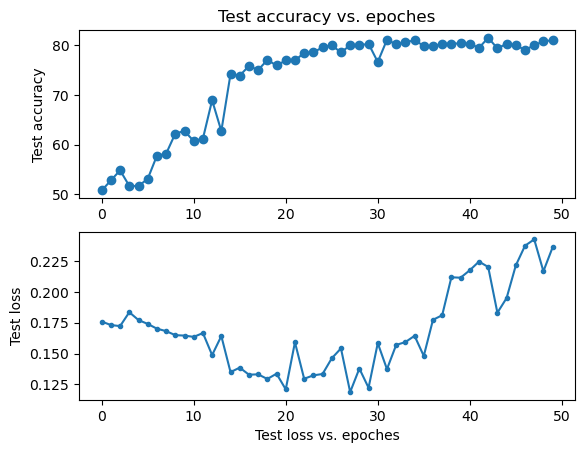

In [13]:
import matplotlib.pyplot as plt

x1 = range(0, 50)
x2 = range(0, 50)
y1 = accuracy_list
y2 = loss_list
plt.subplot(2, 1, 1)
plt.plot(x1, y1, 'o-')
plt.title('Test accuracy vs. epoches')
plt.ylabel('Test accuracy')
plt.subplot(2, 1, 2)
plt.plot(x2, y2, '.-')
plt.xlabel('Test loss vs. epoches')
plt.ylabel('Test loss')
plt.show()
# plt.savefig("accuracy_loss.jpg")


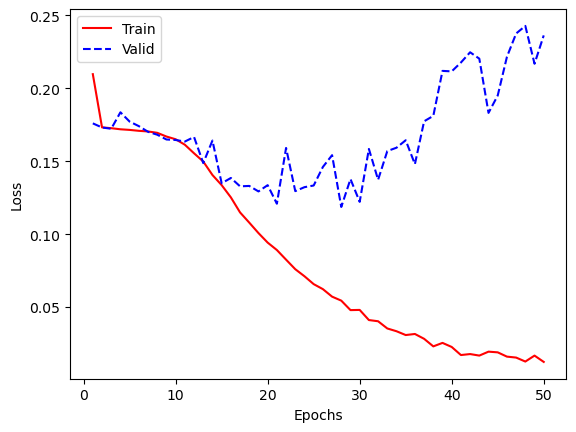

In [14]:
#distplot
import matplotlib.pyplot as plt
epochs =[i+1 for i in range(50)]
plt.plot(epochs,tr_loss_list, color='red', label='Train')
plt.plot(epochs,loss_list, '--', color='blue', label='Valid')
#plt.title('CrossEntropy') # title
plt.ylabel("Loss") # y label
plt.xlabel("Epochs") # x label
plt.legend() #圖例
#plt.savefig('.\\Model\\0618\\t_model_' + str(isbalence) + 'bz' + str(batch_sizes) + '_' + str(num_epochs) + '.png') #儲存圖檔
#plt.savefig('.\\Model\\0618\\實驗' + str(testnum) + '.png') #儲存圖檔
plt.show()

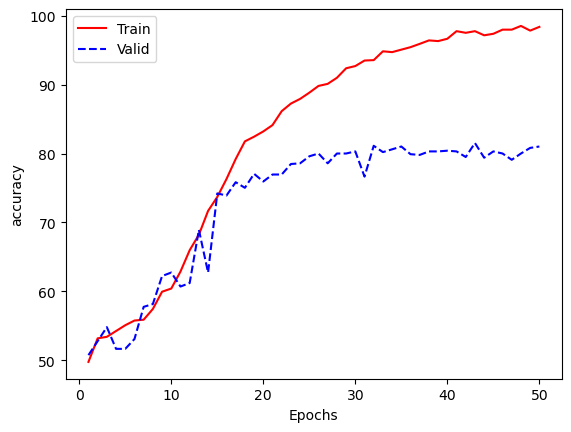

In [15]:
#distplot
import matplotlib.pyplot as plt
epochs =[i+1 for i in range(50)]
plt.plot(epochs,tr_accuracy_list, color='red', label='Train')
plt.plot(epochs,accuracy_list, '--', color='blue', label='Valid')
#plt.title('CrossEntropy') # title
plt.ylabel("accuracy") # y label
plt.xlabel("Epochs") # x label
plt.legend() #圖例
#plt.savefig('.\\Model\\0618\\t_model_' + str(isbalence) + 'bz' + str(batch_sizes) + '_' + str(num_epochs) + '.png') #儲存圖檔
#plt.savefig('.\\Model\\0618\\實驗' + str(testnum) + '.png') #儲存圖檔
plt.show()

In [12]:
torch.save(model.state_dict(), "Resnet18_0809.pt")


In [16]:
#混淆矩陣
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_true, y_pred)

In [18]:

tp=cm[0][0]
fn=cm[0][1]
fp=cm[1][0]
tn=cm[1][1]
print("Accuracy:",(tp+tn)/1000 )

p_presicion=tp/(tp+fp)
p_recall=tp/(tp+fn)
print('FIT precision:',p_presicion)
print('FIT recall:',p_recall)

n_presicion=tn/(tn+fn)
n_recall=tn/(fp+tn)
print('n_FIT precision:',n_presicion)
print('n_FIT recall:',n_recall)

print("F1",(2*p_presicion*p_recall)/(p_presicion+p_recall))

Accuracy: 35.982
FIT precision: 0.7300933552992861
FIT recall: 0.74452
n_FIT precision: 0.7311416063310322
n_FIT recall: 0.7162474226804124
F1 0.7372361072602686


[0.      0.25548 1.     ] [0.         0.71624742 1.        ] [2 1 0]


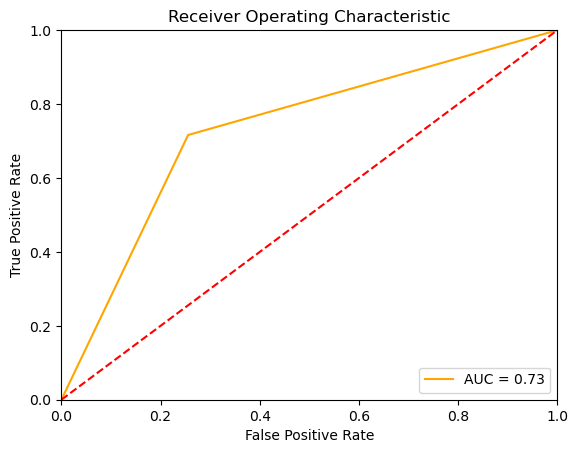

In [19]:
from sklearn.metrics import roc_curve, roc_auc_score, auc
import matplotlib.pyplot as plt
fpr, tpr, threshold = roc_curve(y_true, y_pred)
print(fpr, tpr, threshold)

auc1 = auc(fpr, tpr)
## Plot the result
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, color = 'orange', label = 'AUC = %0.2f' % auc1)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()    